# Loan Default Predictor

This is data from a random sample of loans obtained from a peer-to-peer lending platform with the goal to predict who will default at its loan using features provided in the data. This problem is counted as a binary classification problem. In this notebook, multiple models are used to predict who would default at their loan and in the evaluation section an extensive comparison between models is made. **This notebook only covers task one of the entire assignment.**

## Import packages

In [10]:
import warnings
import pickle
import platform
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from pandas import DataFrame
from numpy.random import RandomState
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from keras.metrics import MeanSquaredError
from keras.models import Sequential, load_model
from keras.layers import Conv1D, BatchNormalization, Activation, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from IPython.display import display, clear_output
from datetime import datetime as dt

## Ignore warnings

In [11]:
# filter and ignore warnings
warnings.filterwarnings('ignore')

## Define constants and methods

In [12]:
# Alpha values to be used for Lasso and Ridge regression models
ALPHA = np.arange(0.01, 100.01, 0.01)
# Best DNN model file path
FILE_PATH = 'best_model.h5'

In [13]:
def encode_scale_features(train, test) -> tuple:
  """Encode categorical values using OrdinalEncoder
    and normalise numerical data using MinMaxScaler.

    Args:
      train (DataFrame): Training dataset.
      test (DataFrame): Testing dataset.

    Returns:
    tuple: A tuple containing two DataFrames: encoded and scaled training and testing datasets.
  """
  encoder = OrdinalEncoder()
  scaler = MinMaxScaler()

  for col in train.columns:
    if train[col].dtype == 'object':
      # Fit on training data
      encoder = encoder.fit(train[col].to_numpy().reshape(-1, 1))

      # Apply transformation for training and testing data
      train[col] = DataFrame(encoder.transform(train[col].to_numpy().reshape(-1, 1)))
      test[col] = DataFrame(encoder.transform(test[col].to_numpy().reshape(-1, 1)))
    else:
      # Fit on training data
      scaler = scaler.fit(train[col].to_numpy().reshape(-1, 1))

      # Apply transformation for training and testing data
      train[col] = DataFrame(scaler.transform(train[col].to_numpy().reshape(-1, 1)))
      test[col] = DataFrame(scaler.transform(test[col].to_numpy().reshape(-1, 1)))

  return (train, test)

def impute_missing_vals(train, test) -> tuple:
  """Impute missing values with mean value for contineous data
    and mode for categorical data.

    Args:
      train (DataFrame): Training dataset.
      test (DataFrame): Testing dataset.

    Returns:
    tuple: A tuple containing two DataFrames: imputed training and testing datasets.
  """
  for col in train.columns:
    # Impute missing values in training data
    if train[col].dtype != 'object' and train[col].isna().sum() > 0:
      # Impute noncategorical features
      train[col] = train[col].fillna(train[col].mean())
    elif train[col].dtype == 'object' and train[col].isna().sum() > 0:
      # Impute categorical features
      train[col] = train[col].fillna(train[col].mode()[0])

    # Impute missing values in testing data
    if test[col].dtype != 'object' and test[col].isna().sum() > 0:
      # Impute noncategorical features
      test[col] = test[col].fillna(test[col].mean())
    elif test[col].dtype == 'object' and test[col].isna().sum() > 0:
      # Impute categorical features
      test[col] = test[col].fillna(test[col].mode()[0])

  return (train, test)

def plot_corr_heatmap(method, X_train) -> None:
  """Compute correlation matrix and plot correlation heatmap

    Args:
      method (str): Correlation method to use.
      X_train (DataFrame): Training dataset.
  """
  # Compute correlation matrix.
  corr = X_train.corr(method=method)

  plt.figure(figsize=(30, 15))
  heatmap = sb.heatmap(corr.sort_values(by='loan_status', ascending=False), annot=True)

  # Save heatmap to disk in a png format.
  figure = heatmap.get_figure()
  figure.savefig("heatmap_" + method + ".png", dpi=400)

def assert_datasets(X_train, y_train, X_test, y_test) -> tuple:
  """Apply assertion on training and testing datasets

    Args:
      X_train (DataFrame): Training features dataset.
      y_train (DataFrame): Training label dataset.
      X_test (DataFrame): Testing features dataset.
      y_test (DataFrame): Testing label dataset.

    Returns:
    tuple: A tuple containing four DataFrames: X_train, y_train, X_test, y_test.
  """
  # Assert no missing values.
  assert X_train.isna().sum().sum() == 0
  assert X_test.isna().sum().sum() == 0
  assert y_test.isna().sum().sum() == 0
  assert y_train.isna().sum().sum() == 0

  # Assert datasets are scaled.
  assert y_train['loan_status'].max() == 1.0
  assert y_train['loan_status'].min() == 0.0
  assert y_test['loan_status'].max() == 1.0
  assert y_test['loan_status'].min() == 0.0


  return (X_train, y_train, X_test, y_test)

def prepare_dataset(train, test, drop_highly_corr_feat=False, cols_to_remove=[]) -> tuple:
  """Prepare datasets by applying the following:
        - Drop useless columns: mths_since_last_delinq, member_id, id
        - Drop more columns if drop_highly_corr_feat & cols_to_remove is set
        - Impute missing numerical and categorical values
        - Encode categorical values and scale numerical values
        - Segregate features from labels
        - Standardise datasets

    Args:
      train (DataFrame): Training dataset.
      test (DataFrame): Testing dataset.
      drop_highly_corr_feat (boolean): Indicates wether to drop further columns or not.
      cols_to_remove (list): List of further columns to drop if drop_highly_corr_feat is set to True.

    Returns:
    tuple: A tuple containing four DataFrames: X_train, y_train, X_test, y_test.
  """
  # Drop highly correlated features for model stability.
  if drop_highly_corr_feat:
    train, test = remove_highly_correlated_feat(train, test, cols_to_remove)
  # Drop id, member_id, mths_since_last_delinq columns.
  train.drop(columns=['id', 'member_id', 'mths_since_last_delinq'], inplace=True)
  test.drop(columns=['id', 'member_id', 'mths_since_last_delinq'], inplace=True)

  # Replace Charged Off with 1, 0 otherwise.
  train['loan_status'] = train['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
  test['loan_status'] = test['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

  # Impute missing values.
  train, test = impute_missing_vals(train, test)

  # Encode categorical features.
  train, test = encode_scale_features(train, test)

  # Segregate features from labels.
  X_train, y_train = segregate_label_from_feat(train)
  X_test, y_test = segregate_label_from_feat(test)

  # Standardise datasets.
  # Fit scaler on training data.
  scaler = StandardScaler().fit(X_train)

  # Transform both training and testing datasets.
  X_train = DataFrame(scaler.transform(X_train), columns=X_train.columns)
  X_test = DataFrame(scaler.transform(X_test), columns=X_test.columns)

  # Assert and return datasets.
  return assert_datasets(X_train, y_train, X_test, y_test)

def segregate_label_from_feat(df):
  """Segregate labels from features.

    Args:
      df (DataFrame): Dataset that could be training or testing.

    Returns:
      tuple: A tuple containing two DataFrames: features dataframe and label dataframe
  """
  y, X = (DataFrame(df['loan_status']), df.drop(columns=['loan_status']))
  return (X, y)

def run_models_for_diff_alphas(
    model,
    X_train,
    X_test,
    y_train,
    y_test) -> tuple[list, list]:
  """Runs Ridge or Lasso regression models with different alpha values
    and calculates the mean squared error (MSE)
    for both training and testing datasets.

    Args:
      model (str): Type of model to run. Should be 'ridge' or 'lasso'.
      X_train (DataFrame): Training input features.
      X_test (DataFrame): Testing input features.
      y_train (DataFrame): Training labels.
      y_test (DataFrame): Testing labels.

    Returns:
      tuple: A tuple containing two lists: MSE values for training
      and testing datasets, respectively.
  """

  mse_train, mse_test = [], []

  for alpha in ALPHA:
    # Clear display.
    clear_output(wait=True)
    # Display current alpha value.
    display(alpha)

    # Build and fit model.
    if model == 'ridge':
      reg = Ridge(alpha=alpha).fit(X_train, y_train)
    elif model == 'lasso':
      reg = Lasso(alpha=alpha).fit(X_train, y_train)

    # Compute y_pred for training and testing.
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)

    # Compute MSEs and append values to lists.
    mse_train.append(mean_squared_error(y_train, y_pred_train))
    mse_test.append(mean_squared_error(y_test, y_pred_test))

  return (mse_train, mse_test)

def plot_mse(mse_train, mse_test) -> None:
  """Plot mse values for both training and testing datasets on one plot.

    Args:
        mse_train (list): List of mse values for training dataset.
        mse_test (list): List of mse values for testing dataset.
  """
  plt.figure(figsize=(10,6))

  plt.plot(np.arange(0.01, 100.01, 0.01), mse_train, label='mse_train',
           marker='o', markerfacecolor='blue')
  plt.plot(np.arange(0.01, 100.01, 0.01), mse_test, label='mse_test',
           marker='o', markerfacecolor='green')

  plt.xlabel("Alpha")
  plt.ylabel("MSE")
  plt.legend()
  plt.title('MSE for both training & testing datasets')
  plt.show()

def remove_highly_correlated_feat(train, test, cols) -> tuple:
  """Plot feature importance bar chart.

    Args:
        train (DataFrame): Training dataset.
        test (DataFrame): Testing dataset.
        cols (list): List of columns to drop.

    Returns:
      tuple: A tuple containing two DataFrames: training and testing datasets
  """
  train.drop(columns=cols, inplace=True)
  test.drop(columns=cols, inplace=True)

  return (train, test)

def plot_feat_importance(feature_importances, columns) -> None:
  """Plot feature importance bar chart.

    Args:
        feature_importances (numpy.array): Numpy array of feature importance.
        columns (list): List of columns of the dataset.
  """
  plt.figure(figsize=(10,6))

  feat_importance = pd.Series(feature_importances, index=columns)
  feat_importance.sort_values(ascending=True, inplace=True)
  feat_importance.plot.barh(color='green')

  plt.xlabel("Importance")
  plt.ylabel("Feature")
  plt.title("Feature Importance")

def reshape_datasets(train, test):
  """Reshape traing and testing datasets for Conv1D input (samples, time steps, features)

    Args:
        train (DataFrame): Training dataset
        test (DataFrame): Testing dataset

    Returns:
      tuple: A tuple containing two DataFrames: reshaped training and testing datasets
  """
  X_train = DataFrame(train, columns=train.columns).to_numpy()
  X_train = X_train.reshape(train.shape[0], train.shape[1], 1)

  X_test = DataFrame(test, columns=test.columns).to_numpy()
  X_test = X_test.reshape(test.shape[0], test.shape[1], 1)

  return (train, test)


def create_model(X_train):
  """Create encoder-classifier model

    Args:
        X_train (DataFrame): Training dataset

    Returns:
      Model: Return DNN model
  """
  model = Sequential()

  # Encoder
  model.add(Conv1D(64, kernel_size=4, strides=2, padding="same",
                   input_shape=(X_train.shape[1], 1)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Conv1D(64, kernel_size=4, padding="same", strides=2))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Conv1D(64, kernel_size=4, padding="same", strides=2))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Conv1D(64, kernel_size=4, padding="same", strides=2))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  model.add(Flatten())

  # Classifier
  model.add(Dense(1))
  model.add(Activation("sigmoid"))

  model.summary()

  return model

def get_optimiser():
  """Switch to legacy adam on apple silicon devices

    Returns:
      Optimizer: Return adam or legacy adam optimiser
  """
  if platform.system() == "Darwin" and platform.processor() == "arm":
      return tf.keras.optimizers.legacy.Adam()
  else:
      return tf.keras.optimizers.Adam()

def get_callback_list():
  """Create callback that saves the best model during the training phase

    Returns:
      list: List of callbacks.
  """
  return [ModelCheckpoint(FILE_PATH, monitor='val_mean_squared_error',
                          verbose=1, save_best_only=True, mode='min')]



# Task One - Use different ML models for classification and evaluate them

## Explore and Prepare datasets

In [14]:
# Load datasets.
train = pd.read_csv("/content/sample_data/trainData.csv")
test = pd.read_csv("/content/sample_data/testData.csv")

In [15]:
# Deep copy datasets.
train_copy, test_copy = train.copy(), test.copy()

# Prepare datasets.
# Set random_state for reproducibly.
X_train, y_train, X_test, y_test = prepare_dataset(train_copy.sample(frac=1, random_state=RandomState(1)),
                                                   test_copy.sample(frac=1, random_state=RandomState(1)),
                                                   drop_highly_corr_feat=False)

# Merge label and features after preprocessing for computing correlation
# between features and the label.
X_train_merged = X_train.copy()
X_train_merged['loan_status'] = y_train.copy()

#### Compute correlation matrix between features using Kendall Tau correlation

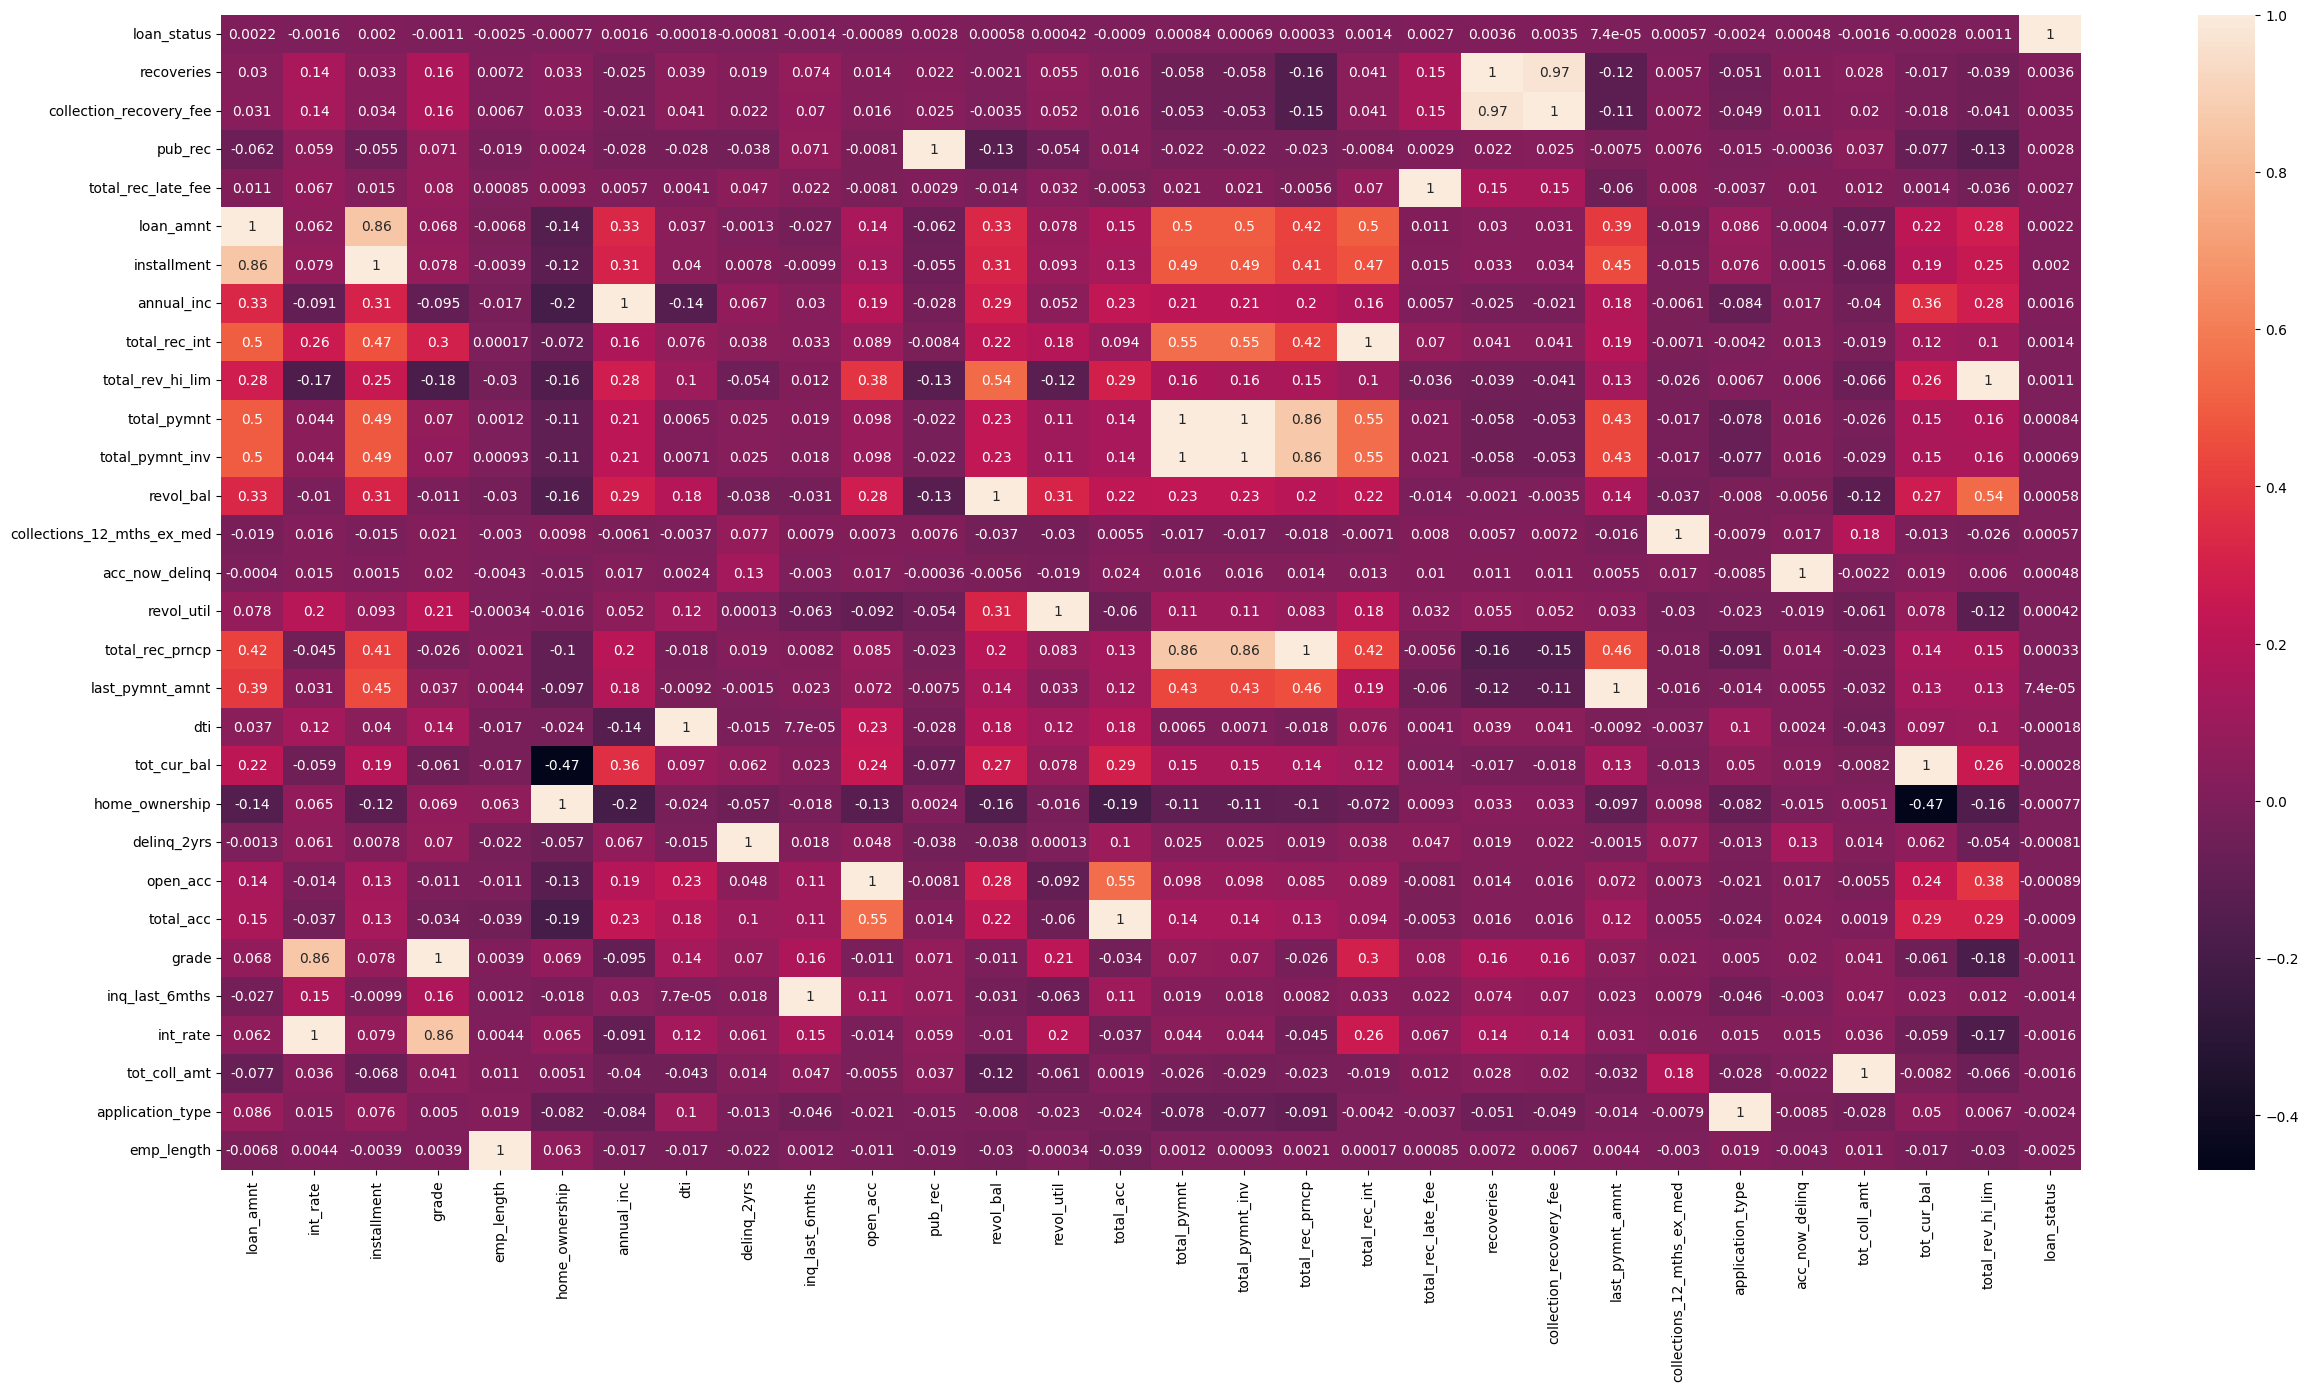

In [16]:
plot_corr_heatmap("kendall", X_train_merged)

#### Compute correlation matrix between features using Spearman rank correlation

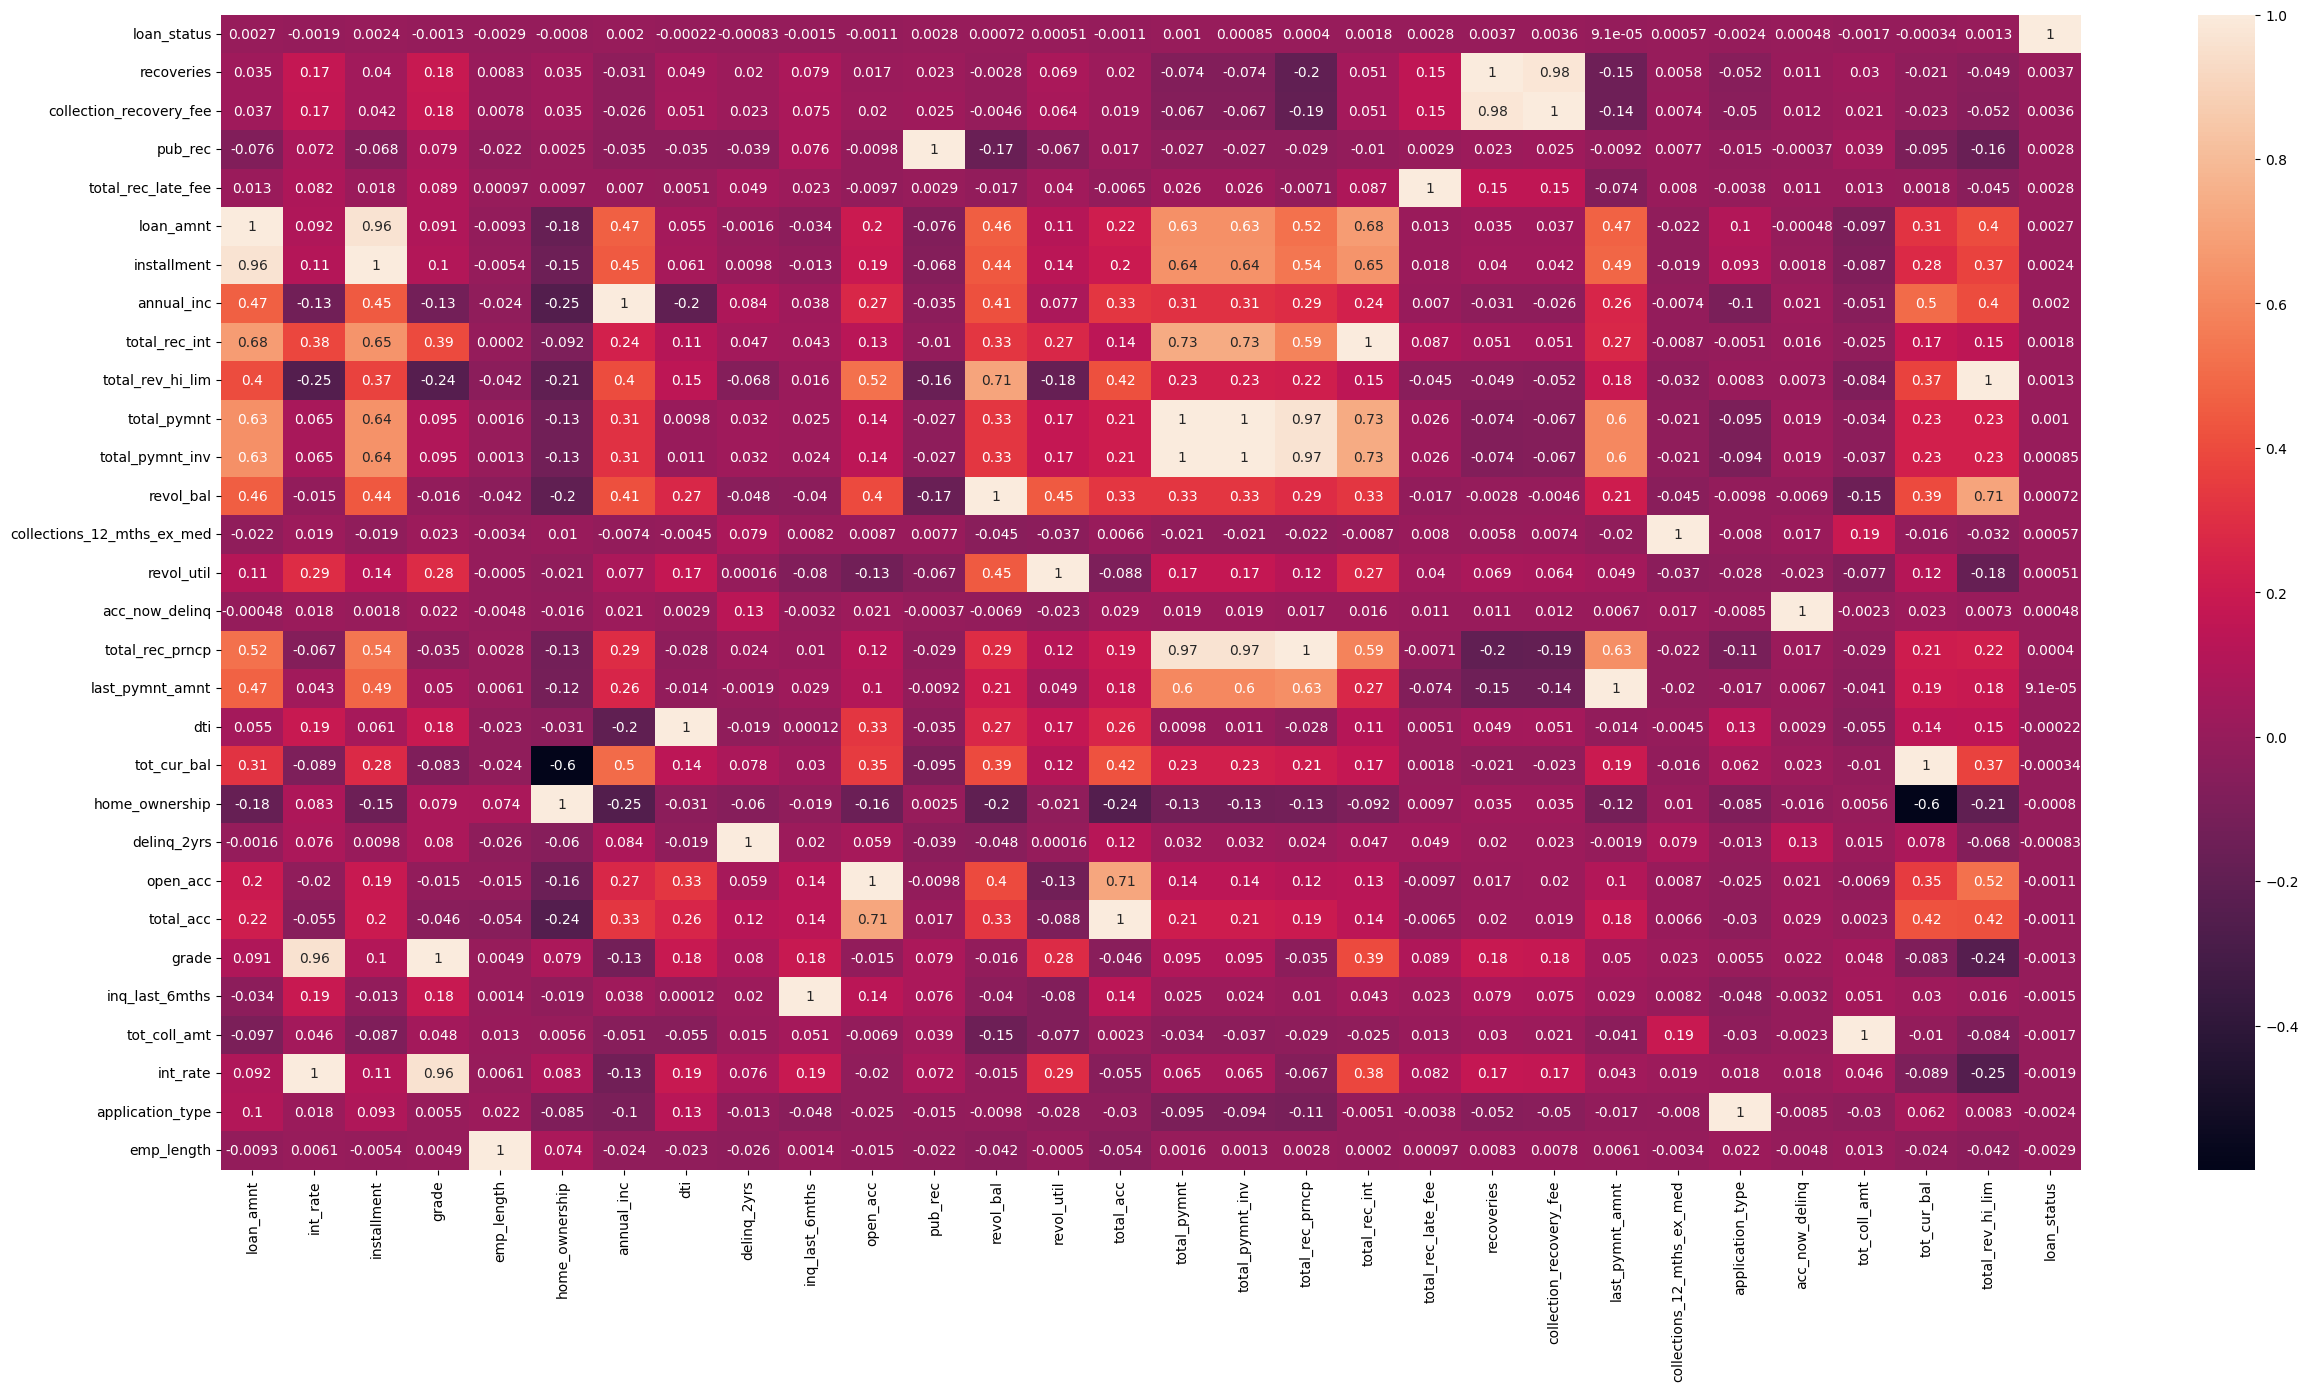

In [17]:
plot_corr_heatmap("spearman", X_train_merged)

## Linear Regression Model

In [18]:
# Define y_pred and mse dicts.
lr_y_pred, lr_mse = {}, {}

start = dt.now()
# Fit a linear regression model.
reg = LinearRegression().fit(X_train, y_train)
# Calculate how much time taken to train the model.
lr_training_time = (dt.now() - start)

# Compute y_pred for training and testing datasets.
lr_y_pred['training'], lr_y_pred['testing'] = reg.predict(X_train), reg.predict(X_test)

# Compute mse for training and testing datasets.
lr_mse['training'], lr_mse['testing'] = mean_squared_error(y_train, lr_y_pred['training']), mean_squared_error(y_test, lr_y_pred['testing'])

### Training Time

In [19]:
# Print total seconds taken to train the model
print("Time taken to fit a linear regression model:", lr_training_time.total_seconds())

Time taken to fit a linear regression model: 0.567094


### Mean Squared Error

In [20]:
# Print mse values at the best alpha value for both datasets
print("MSE for training:", lr_mse['training'])
print("MSE for testing:", lr_mse['testing'])

MSE for training: 0.06787453128970664
MSE for testing: 0.06866392170296558


## Ridge Regression Model

100.00000000000001

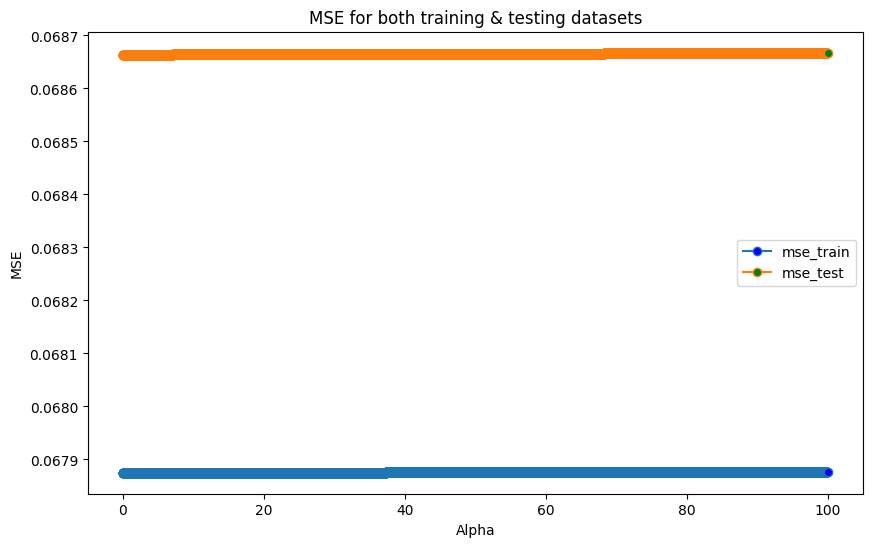

In [21]:
# Create and fit ridge regression model for different alpha values from 0.01 to 100.0
ridge_mse_train, ridge_mse_test = run_models_for_diff_alphas('ridge', X_train, X_test, y_train, y_test)

# Plot mse for each alpha for both datasets
plot_mse(ridge_mse_train, ridge_mse_test)

#### Mean Squared Error

In [22]:
# Print mse values at the best alpha value for both datasets
print("Best MSE for training:", min(ridge_mse_train), "at alpha:", ALPHA[ridge_mse_train.index(min(ridge_mse_train))])
print("Best MSE for testing:", min(ridge_mse_test), "at alpha:", ALPHA[ridge_mse_test.index(min(ridge_mse_test))])

Best MSE for training: 0.06787500402817544 at alpha: 0.01
Best MSE for testing: 0.06866407796320675 at alpha: 0.01


#### Calculate Training Time for the Best Model

In [23]:
# Best model alpha
alpha = ALPHA[ridge_mse_test.index(min(ridge_mse_test))]

start = dt.now()
# Fit a linear regression model.
ridge_reg = Ridge(alpha=alpha).fit(X_train, y_train)
# Calculate how much time taken to train the model.
ridge_training_time = (dt.now() - start)

# Print total seconds taken to train the model
print("Time taken to fit a ridge regression model:", ridge_training_time.total_seconds())

Time taken to fit a ridge regression model: 0.074314


## Lasso Regresion Model

100.00000000000001

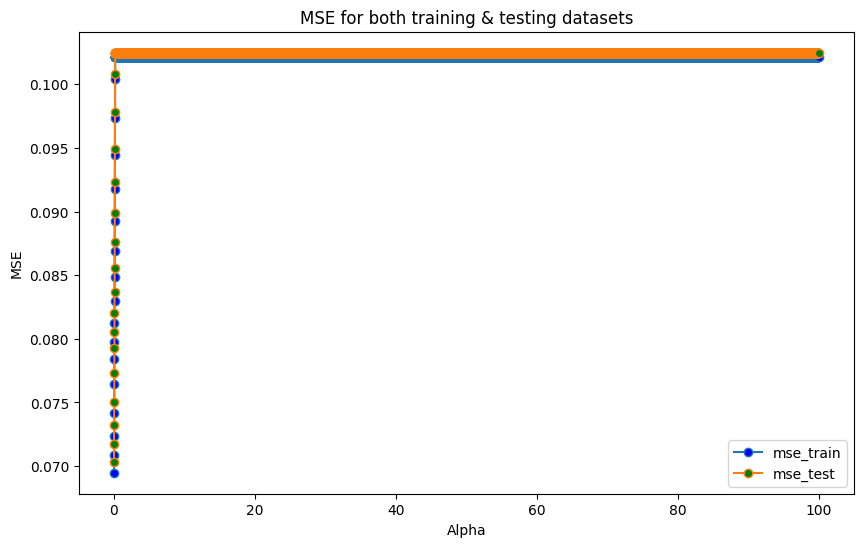

In [24]:
# Create and fit lasso regression model for different alpha values from 0.01 to 100.0
lasso_mse_train, lasso_mse_test = run_models_for_diff_alphas('lasso', X_train, X_test, y_train, y_test)

# Plot mse for each alpha for both datasets.
plot_mse(lasso_mse_train, lasso_mse_test)

#### Mean Squared Error

In [25]:
# Print mse values at the best alpha value for both datasets
print("Best MSE for training:", min(lasso_mse_train), "at alpha:", ALPHA[lasso_mse_train.index(min(lasso_mse_train))])
print("Best MSE for testing:", min(lasso_mse_test), "at alpha:", ALPHA[lasso_mse_test.index(min(lasso_mse_test))])

Best MSE for training: 0.06947359372273494 at alpha: 0.01
Best MSE for testing: 0.0703383450676996 at alpha: 0.01


#### Calculate Training Time for the Best Model

In [26]:
# Best model alpha
alpha = ALPHA[lasso_mse_test.index(min(lasso_mse_test))]

start = dt.now()
# Fit a linear regression model.
lasso_reg = Lasso(alpha=alpha).fit(X_train, y_train)
# Calculate how much time taken to train the model.
lasso_training_time = (dt.now() - start)

# Print total seconds taken to train the model
print("Time taken to fit a lasso regression model:", lasso_training_time.total_seconds())

Time taken to fit a lasso regression model: 0.199593


## Random forest classifier

### Random forest classifier - without dropping highly correlated feat

In [27]:
# Define random_forest_y_pred and random_forest_mse dicts.
random_forest_y_pred, random_forest_mse = {}, {}

# Current time == start time.
start = dt.now()
# Fit a random forest classifier model.
clf = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
# Calculate how much time taken to train the model.
running_secs = (dt.now() - start)

# Compute y_pred for training and testing datasets.
random_forest_y_pred['training'], random_forest_y_pred['testing'] = clf.predict(X_train), clf.predict(X_test)

# Compute mse for training datasets.
random_forest_mse['training'] = mean_squared_error(y_train, random_forest_y_pred['training'])

# Compute mse for testing datasets.
random_forest_mse['testing'] =  mean_squared_error(y_test, random_forest_y_pred['testing'])

#### Training Time

In [28]:
# Print total seconds taken to train the model
print("Time taken to fit a random forest classifier model:", running_secs.total_seconds())

Time taken to fit a random forest classifier model: 107.122842


#### Mean Squared Error

In [29]:
# Print mse values for both datasets
print("MSE for training:", random_forest_mse['training'])
print("MSE for testing:", random_forest_mse['testing'])

MSE for training: 8.846934758279625e-06
MSE for testing: 0.0339324182653815


#### Feature Importance

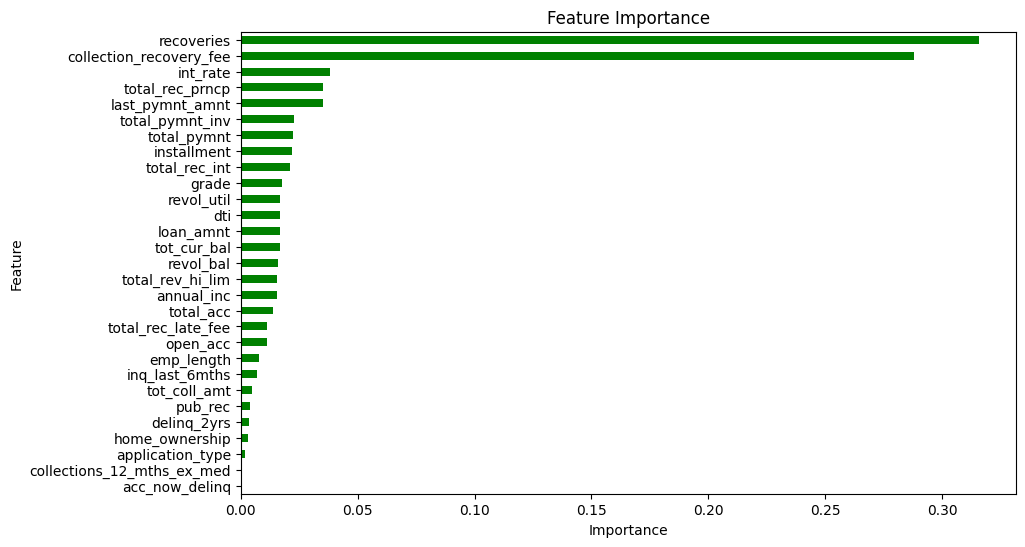

In [30]:
# Plot feature importance
plot_feat_importance(clf.feature_importances_, X_train.columns)

#### How important are the variables in predicting default?

As shown in the figure building this model heavily depends on two features, recoveries and collection_recovery_fee. Also, the difference between the feature importance values is massive. As the difference between recoveries and collection_recovery_fee is reasonable. Though, the difference between collection_recovery_fee and int_rate is massive.

### Random forest classifier - with dropping highly correlated feat

This is an attempt of removing the most correlated features - **recoveries** and **collection_recovery_fee** - in order to observe their effect on the MSE

In [31]:
# Prepare datasets
# Drop the highest correlated features for model stability
X_train, y_train, X_test, y_test = prepare_dataset(train.sample(frac=1, random_state=RandomState(1)),
                                                   test.sample(frac=1, random_state=RandomState(1)),
                                                   drop_highly_corr_feat=True,
                                                   cols_to_remove=['recoveries', 'collection_recovery_fee'])

In [32]:
# Define rf_y_pred and rf_mse dicts.
rf_y_pred, rf_mse = {}, {}

# Current time == start time.
start = dt.now()
# Fit a random forest classifier model.
clf = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
# Calculate how much time taken to train the model.
running_secs = (dt.now() - start)

# Compute y_pred for training and testing datasets.
rf_y_pred['training'], rf_y_pred['testing'] = clf.predict(X_train), clf.predict(X_test)

# Compute mse for training and testing datasets.
rf_mse['training'], rf_mse['testing'] = mean_squared_error(y_train, rf_y_pred['training']), mean_squared_error(y_test, rf_y_pred['testing'])

#### Training Time

In [33]:
# Print total seconds taken to train the model
print("Time taken to fit a random forest classifier model:", running_secs.total_seconds())

Time taken to fit a random forest classifier model: 114.67202


#### Mean Squared Error

In [34]:
# Print mse values for both datasets
print("MSE for training:", rf_mse['training'])
print("MSE for testing:", rf_mse['testing'])

MSE for training: 4.4234673791398125e-06
MSE for testing: 0.05880115187090553


#### Feature Importance

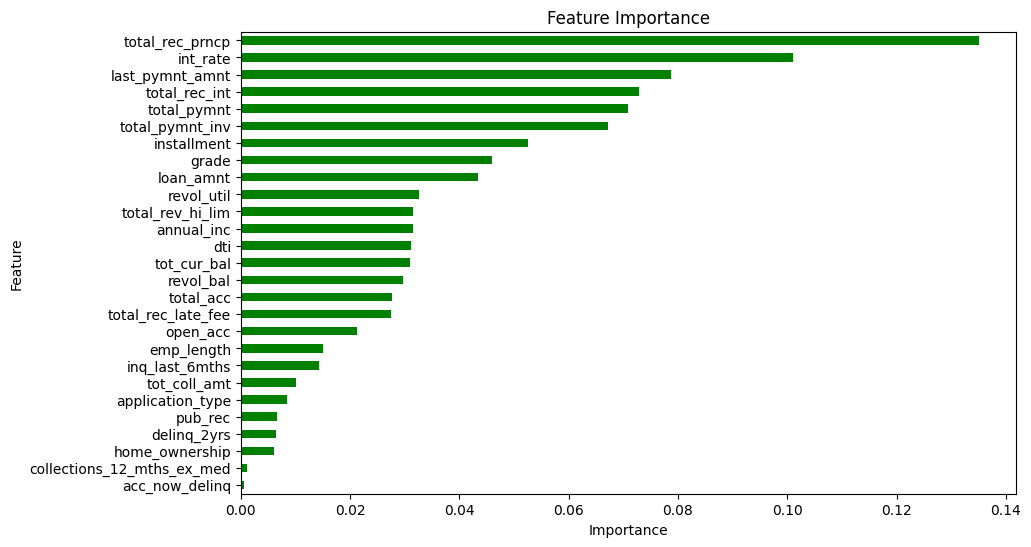

In [35]:
# Plot feature importance
plot_feat_importance(clf.feature_importances_, X_train.columns)

#### How important are the variables in predicting default?

Unlike the other classifier, this attempt building the model depends on pretty much all the features except for two or so. Also, the difference in importance between features is not that massive like the classifier above. As for the most important feature - total_rec_prncp - it has a value of approx. 0.13 and the second most important feature - int_rate - has a value of approx. 0.11.

This is an attempt of removing the second most correlated features - **collection_recovery_fee** - in order to observe their effect on the MSE

In [36]:
# Prepare datasets
# Drop the second highest correlated features for model stability
X_train, y_train, X_test, y_test = prepare_dataset(train.sample(frac=1, random_state=RandomState(1)),
                                                   test.sample(frac=1, random_state=RandomState(1)),
                                                   drop_highly_corr_feat=True, cols_to_remove=['collection_recovery_fee'])

In [37]:
# Define rf_y_pred and rf_mse dicts.
rf_y_pred, rf_mse = {}, {}

# Current time == start time.
# Fit a random forest classifier model.
clf = RandomForestClassifier(max_depth=100, random_state=0).fit(X_train, y_train)
# Calculate how much time taken to train the model.
rfc_training_time = (dt.now() - start)

# Compute y_pred for training and testing datasets.
rf_y_pred['training'], rf_y_pred['testing'] = clf.predict(X_train), clf.predict(X_test)

# Compute mse for training and testing datasets.
rf_mse['training'], rf_mse['testing'] = mean_squared_error(y_train, rf_y_pred['training']), mean_squared_error(y_test, rf_y_pred['testing'])

#### Training Time - this is the best model

In [38]:
# Print total seconds taken to train the model
print("Time taken to fit a random forest classifier model:", rfc_training_time.total_seconds())

Time taken to fit a random forest classifier model: 237.041963


#### Mean Squared Error

In [39]:
# Print mse values for both datasets
print("MSE for training:", rf_mse['training'])
print("MSE for testing:", rf_mse['testing'])

MSE for training: 4.4234673791398125e-06
MSE for testing: 0.03379529077662817


#### Feature Importance

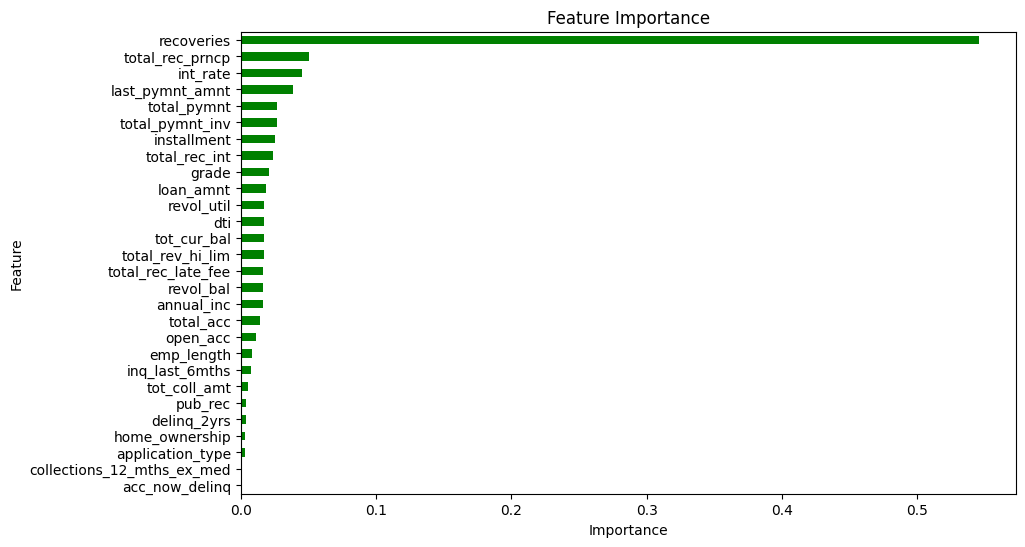

In [40]:
# Plot feature importance
plot_feat_importance(clf.feature_importances_, X_train.columns)

#### How important are the variables in predicting default?

Like the first classifier, building this model heavily depends on the feature recoveries even more than the first model. It seems that removing collection_recovery_fee helped the model to outperform those which used considered this feature whilst training. The difference is not massive though, but it still outperformed the other classifiers. Not to mention the the difference in the importance value between the most important and the least important features is massive. As for recoveries it has a value above 0.5 and for the second importance feature - total_rec_prncp - it has an importance value below 0.1.

## Neural network

#### Why this Architecture?

This DNN architecture consists of two parts - a compact encoder and a classifier - and **50817** trainable parameters. The encoder part consists of 4 **4x4 CNN1D** with **64 filters** and **2 strides** each, batch normalization - this was used to make the training process faster and make the DNN more stable through normalization of the layers' inputs by re-centering and re-scaling - and ReLU activation is applied after each convolution. The main purpose of this encoder is to perform feature extraction. It selects the most important features and then pass them to the classifier. The classifier, on the other hand, consists of one dense layer with only 1 unit and sigmoid activation is applied. As the name states, this output a number between 0 and 1 since its a binary classification problem.

On contrast if I chose an architecture consists only of MLPs that would come with various limitations. For example, MLP doesn't do feature extraction, it only assign weights to each feature according to how important it is and according to the learnt pattern. Also, I might have needed more parameters to train or more layers to stack on top of each other to achieve what I have achieved with the used model.

In [41]:
# Reshape X for Conv1D input (samples, time steps, features)
X_train, X_test = reshape_datasets(X_train, X_test)

# Create model.
model = create_model(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 14, 64)            320       
                                                                 
 batch_normalization (Batch  (None, 14, 64)            256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 14, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             16448     
                                                                 
 batch_normalization_1 (Bat  (None, 7, 64)             256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 7, 64)             0

In [42]:
# Compile model.
model.compile(optimizer=get_optimiser(), loss='binary_crossentropy', metrics=[MeanSquaredError()])

# Current time == start time.
start = dt.now()
# Fit a deep learning model.
# The result is not reproducibly.
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=get_callback_list())
# Calculate how much time taken to train the model.
nn_training_time = (dt.now() - start)

Epoch 1/10
5649/5652 [============================>.] - ETA: 0s - loss: 0.1428 - mean_squared_error: 0.0379
Epoch 1: val_mean_squared_error improved from inf to 0.03451, saving model to best_model.h5
5652/5652 [==============================] - 54s 9ms/step - loss: 0.1428 - mean_squared_error: 0.0379 - val_loss: 0.1316 - val_mean_squared_error: 0.0345
Epoch 2/10
5652/5652 [==============================] - ETA: 0s - loss: 0.1296 - mean_squared_error: 0.0345
Epoch 2: val_mean_squared_error improved from 0.03451 to 0.03279, saving model to best_model.h5
5652/5652 [==============================] - 52s 9ms/step - loss: 0.1296 - mean_squared_error: 0.0345 - val_loss: 0.1233 - val_mean_squared_error: 0.0328
Epoch 3/10
5651/5652 [============================>.] - ETA: 0s - loss: 0.1254 - mean_squared_error: 0.0334
Epoch 3: val_mean_squared_error improved from 0.03279 to 0.03181, saving model to best_model.h5
5652/5652 [==============================] - 52s 9ms/step - loss: 0.1255 - mean_squa

#### Training Time

In [43]:
# Print total seconds taken to train the model
print("Time taken to fit a deep learning model:", nn_training_time.total_seconds())

Time taken to fit a deep learning model: 564.770762


#### Mean Squared Error

In [44]:
# Load best model
model = load_model(FILE_PATH)

# Print mse values for the best model for both datasets, training and testing.
print("MSE for training dataset:", min(history.history['val_mean_squared_error']))
print("MSE for testing dataset:", model.evaluate(x=X_test, y=y_test)[1])

MSE for training dataset: 0.030203770846128464
7065/7065 [==============================] - 25s 3ms/step - loss: 0.1185 - mean_squared_error: 0.0315
MSE for testing dataset: 0.03154117614030838


## Model Evaluation

Training Time for All Models

| Models | Training Time
|----------|----------|
| Linear Regression | 0.567094 s
| Ridge Regression | 0.074314 s
| Lasso Regression | 0.199593 s
| Random Forest Classifier - with all features | 107.122842 s
| Random Forest Classifier - with dropping the most correlated features | 114.67202 s
| Random Forest Classifier - with dropping the second most correlated features | 237.041963 s
| Deep Neural Network | 564.770762 s



Mean Squared Error for All Models

| Models | Training MSE | Testing MSE |
|----------|----------|----------|
| Linear Regression | 0.06787453128970664 | 0.06866392170296558 |
| Ridge Regression @ alpha=0.01| 0.06787500402817544 | 0.06866407796320675 |
| Lasso Regression @ alpha=0.01| 0.06947359372273494| 0.0703383450676996 |
| Random Forest Classifier (100 max depth) - with all features | 8.846934758279625e-06 | 0.0339324182653815 |
| Random Forest Classifier (100 max depth) - with dropping the most correlated features | 4.4234673791398125e-06 | 0.05880115187090553 |
| Random Forest Classifier (100 max depth) - with dropping the second most correlated features | 4.4234673791398125e-06 | 0.03379529077662817 |
| Deep Neural Network (10 epochs)| 0.030203770846128464 | 0.03154117614030838 |



#### Takeaways

Since this is a binary classification problem it was expected that the regression models are not the common approach to go to, and therefore, it obvious that the worst models in terms of MSE values on testing dataset are the worst among the other models. All the regression models used almost have an MSE value of **0.07** which is not good enough compared to the other models.

Although the Deep Neural Network (DNN) architecture consumed a lot of computational power and training time - **564.77 s**, it achieved the lowest MSE on testing data of **0.0315.** Nevertheless, Random Forest Classifier (with dropping the second most correlated features) is considered the second best model as it achieved MSE on testing data of **0.0338.** and consumed **114.67 s** for training the model. Not to mention, the DNN model was only trained for 10 epochs. The MSE value might potentially decrease if the model was trained for longer period of time though. However, for the Random Forest Classifier model if we increase the max depth over 100 the MSE value won't change that much.

I think the difference in the MSE values between these two models is not massive but the difference in training time and computational power consumed is to be considered. Therefore, I'd prefer using the latter model over the DNN model if we are taking into account time and resource management. Otherwise, I'd definitely use the DNN model for prediction since it gave us the lowest loss and theres room for improvement I suppose.
